## Limpeza de dados para exportação de bases de leads para o RD Station

**Preparação:**
- Requisitos;  
- Dados.  

**Limpeza:**  
- Remover espaçamentos;  
- Deixar caracteres minúsculos;  
- Remover e-mails inválidos;  
- Remover e-mails duplicados (em registros e campos).  

**Retorno:**  
- Relatório breve das mudanças aplicadas;  
- Gerar arquivo dos dados tratados para exportação;  
- Gerar arquivo dos dados inválidos para exportação.

---

### Preparação

In [1]:
# imports
import pandas as pd
import numpy as np
import re

In [2]:
# dados
df = pd.read_excel('dados/mailing inscritos 0709.xlsx')

In [3]:
df.shape

(21272, 30)

---

### Limpeza

In [4]:
# Remover espaçamentos

df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [5]:
# Deixar caracteres minúsculos

# criando a coluna 'has_uppercase' e realizando contagem
df['has_uppercase'] = df['Email'].str.contains(r'[A-Z]')
emails_com_letras_maiusculas_antes = df['has_uppercase'].value_counts()

# convertendo emails para lowercase
df['Email'] = df['Email'].str.lower()

# verificando eficácia
df['has_uppercase'] = df['Email'].str.contains(r'[A-Z]')
emails_com_letras_maiusculas_depois = df['has_uppercase'].value_counts()

print(f'Total de emails com letra maiúscula antes da conversão: {emails_com_letras_maiusculas_antes}. Total de emails com letra maiúscula após conversão: {emails_com_letras_maiusculas_depois}')

Total de emails com letra maiúscula antes da conversão: False    21165
True       107
Name: has_uppercase, dtype: int64. Total de emails com letra maiúscula após conversão: False    21272
Name: has_uppercase, dtype: int64


In [6]:
# Remover e-mails inválidos

# função
def is_valid_email(email):
    # Verifica se o email segue o padrão básico de endereço de email
    pattern = r'^[\w\.-]+@[\w\.-]+\.\w+$'
    if re.match(pattern, email) is not None:
        # Verifica se há mais de um "@" no campo
        if email.count('@') == 1:
            return True
    return False

# aplicação
df['email_valido'] = df['Email'].apply(is_valid_email)

# verificação
invalid_count = df['email_valido'].eq(False).sum()
print("Número de emails inválidos:", invalid_count)

# criando df para emails inválidos
df_invalidos = df[df['email_valido'] == False]
df_invalidos

# removendo os emails inválidos do df
df = df[df['email_valido'] == True]

# prints
print(f'Total de registros após remoção de emails inválidos: {df.shape[0]}')
print(f'Total de registros de emails inválidos: {df_invalidos.shape[0]}')

Número de emails inválidos: 17
Total de registros após remoção de emails inválidos: 21255
Total de registros de emails inválidos: 17


In [7]:
# Remover e-mails duplicados (em registros e campos)

# função para remover duplicatas em um mesmo campo
def remove_duplicate_emails(cell):
    unique_emails = list(set(cell.split()))  # Transforma em conjunto para remover duplicatas
    return ' '.join(unique_emails)  # Transforma de volta em string

# aplicando a função
df['Email'] = df['Email'].apply(remove_duplicate_emails)

# função para verificar os registros duplicados
duplicates = df[df.duplicated(subset=['Email'])]

duplicate_counts = duplicates.groupby(duplicates.columns.tolist()).size().reset_index(name='count')
print(f'Total de duplicatas: {duplicate_counts.shape[0]}')

# removendo os registros duplicados
df = df.drop_duplicates(subset=['Email'])
print(f'Total de registro após remoção de duplicatas: {df.shape[0]}')

Total de duplicatas: 0
Total de registro após remoção de duplicatas: 21212


---

### Retorno

In [8]:
# Relatório breve das mudanças aplicadas

print(f'Mantidos e corrigidos: {df.shape[0]}')
print(f'Descartados: {df_invalidos.shape[0]}')

Mantidos e corrigidos: 21212
Descartados: 17


---

### Troubleshooting

Mensagem de erro:

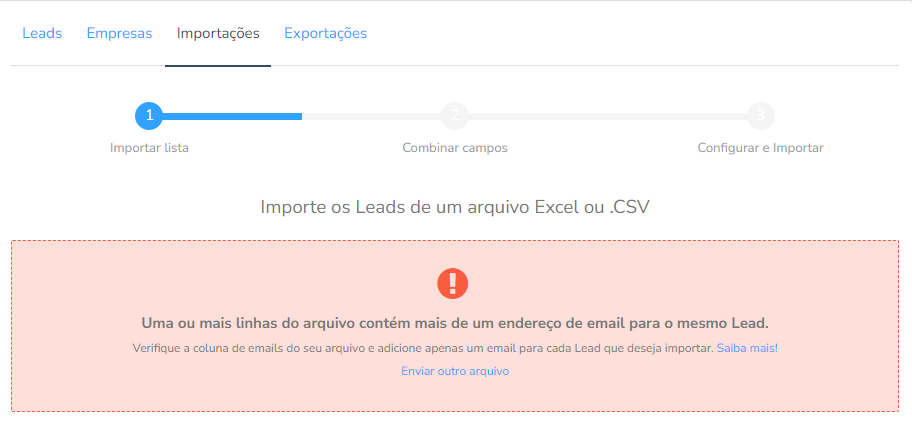

In [9]:
df.columns

Index(['Nome', 'CPF', 'Email', 'País/Country', 'Cidade (City)', 'Estado',
       'Cargo (Job Position)',
       'Inclua seu certificado em curso da beleza (arquivo de até 1 MB, apenas um certificado é o suficiente)',
       'Business Type', 'Nome da Empresa | Company Name',
       'Indique sua Caravana (sua credencial estará com o organizador)',
       'Celular (DDD)', 'Passport Number',
       'Selecione o tipo de comércio que atua',
       'Termos e Condições do Organizador', 'Declaração de Ciência',
       'Qual gênero você se identifica? | Gender', 'Bairro', 'Veículo', 'CNPJ',
       'Presente', 'Status', 'Categoria', 'Atividades Escolhidas',
       'Data de Inscrição', 'Data de Pagamento da Inscrição',
       'Primeiro acesso', 'Último acesso', 'Comentários',
       'Celular do Participante', 'has_uppercase', 'email_valido'],
      dtype='object')

In [10]:
# Função para verificar se há duas "@" no campo
def has_double_at_symbol(email):
    return email.count('@') > 1

# Aplicar a função e criar uma coluna para indicar a ocorrência de duas "@"
df['has_double_at'] = df['Email'].apply(has_double_at_symbol)

In [11]:
df['has_double_at'].value_counts()

False    21212
Name: has_double_at, dtype: int64

In [12]:
df['Nome'].isnull().sum()

1

In [14]:
def extrair_nome(nome):
    match = re.match(r'^[a-zA-Z]+', nome)
    if match:
        return match.group()
    else:
        return nome

In [15]:
# Índices das linhas que você deseja processar
indices_a_processar = [4751, 18892]

In [16]:
for indice in indices_a_processar:
    df.at[indice, 'Nome'] = extrair_nome(df.at[indice, 'Nome'])

In [17]:
# Relatório breve das mudanças aplicadas

print(f'Mantidos e corrigidos: {df.shape[0]}')
print(f'Descartados: {df_invalidos.shape[0]}')

Mantidos e corrigidos: 21212
Descartados: 17


---

### Exportando

In [18]:
df_invalidos.shape

(17, 32)

In [19]:
df.shape

(21212, 33)

In [20]:
df.to_excel('mailing-inscritos-0709.xlsx')

In [21]:
df_invalidos.to_excel('mailing-inscritos-0709_invalidos.xlsx')